In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

import posterior_agreement
import candel
from utils import * 


%matplotlib inline
%load_ext autoreload
%autoreload 2

COLS = ["#87193d", "#1e42b9", "#d42a29", "#05dd6b", "#ee35d5"]

config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config.toml"
root = join("/Users/rstiskalek/Projects/CANDEL/", "results", "S8")

In [2]:
beta2cosmo = candel.cosmo.Beta2Cosmology()

runs = [
    ("precomputed_los_Carrick2015_CF4_W1_MNR_linear_eta_sampled.hdf5", "CF4 TFR W1"),
    ("precomputed_los_Carrick2015_CF4_i_MNR_linear_eta_sampled.hdf5", "CF4 TFR i"),
    ("precomputed_los_Carrick2015_PantheonPlus_MNR_linear.hdf5", "Pantheon+"),
    ("precomputed_los_Carrick2015_SDSS_FP_noMNR_linear.hdf5", "SDSS FP"),
    ("precomputed_los_Carrick2015_6dF_FP_noMNR_linear.hdf5", "6dF FP")
]


filenames = [f[0] for f in runs]
labels = [f[1] for f in runs]
fnames = [join(root, f) for f in filenames]

### Values checks

In [ ]:
key = "Vext_b"
x_list = get_key_all(fnames, key)
for x, label in zip(x_list, labels):
    mean, std = np.mean(x), np.std(x)
    print(f"{label}: {mean:.3f} ± {std:.3f}")

### Table: $b_1$, $\beta$, and $S_8$ values

In [15]:
b1_list   = get_key_all(fnames, "b1")
beta_list = get_key_all(fnames, "beta")
S8_list = compute_S8_all(fnames, beta2cosmo)

for i, (name, b1_samples, beta_samples, S8_samples) in enumerate(zip(labels, b1_list, beta_list, S8_list)):
    b1mean, b1std = np.mean(b1_samples), np.std(b1_samples)
    S8mean, S8std = np.mean(S8_samples), np.std(S8_samples)
    print(f"{name}: b1 = {b1mean:.3f} ± {b1std:.3f} | beta = {np.mean(beta_samples):.3f} ± {np.std(beta_samples):.3f} | S8 = {S8mean:.3f} ± {S8std:.3f}")


CF4 TFR W1: b1 = 1.192 ± 0.012 | beta = 0.475 ± 0.019 | S8 = 0.817 ± 0.042
CF4 TFR i: b1 = 1.088 ± 0.013 | beta = 0.485 ± 0.019 | S8 = 0.832 ± 0.042
Pantheon+: b1 = 1.362 ± 0.054 | beta = 0.500 ± 0.029 | S8 = 0.855 ± 0.053
SDSS FP: b1 = 1.412 ± 0.007 | beta = 0.482 ± 0.006 | S8 = 0.828 ± 0.031
6dF FP: b1 = 1.539 ± 0.005 | beta = 0.452 ± 0.010 | S8 = 0.782 ± 0.032


### Figure: 1D posterior of $S_8$

CF4 TFR W1: 0.817 ± 0.042 | 0.361
CF4 TFR i: 0.833 ± 0.042 | 0.129
Pantheon+: 0.855 ± 0.054 | 0.389
SDSS FP: 0.828 ± 0.031 | 0.084
6dF FP: 0.782 ± 0.032 | 1.433


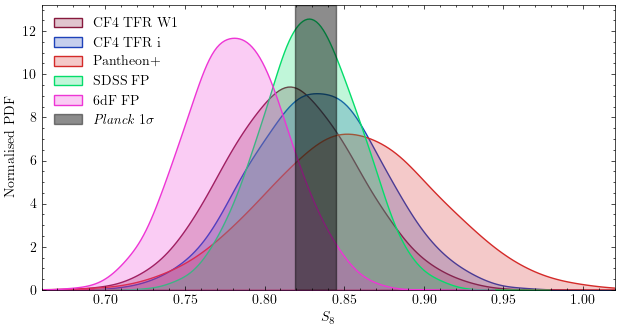

In [17]:
S8_list = compute_S8_all(fnames, beta2cosmo)

bw = 0.25

planck_mean, planck_std = 0.832, 0.013
rng = np.random.default_rng(seed=42)
planck_samples = rng.normal(loc=planck_mean, scale=planck_std, size=100_000)

with plt.style.context("science"):
    plt.figure(figsize=(6.4, 3.5))

    # Plot KDEs for "this work" datasets
    i = 0
    for S8, label in zip(S8_list, labels):
        agreement_1d = posterior_agreement.compute_agreement((planck_samples, S8)).sigma
        print(f"{label}: {np.mean(S8):.3f} ± {np.std(S8):.3f} | {agreement_1d:.3f}")
        sns.kdeplot(S8, label=label, fill=True, color=COLS[i], bw_method=bw)
        i += 1

    # Replace Planck KDE with shaded 1σ band
    plt.axvspan(planck_mean - planck_std, planck_mean + planck_std,
                color="k", alpha=0.45, label=r"\textit{Planck} $1\sigma$")

    plt.xlim(0.66, 1.02)
    plt.xlabel(r"$S_8$")
    plt.ylabel("Normalised PDF")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/S8_posterior.pdf", bbox_inches="tight", dpi=450)
    plt.show()

### Figure: 1D posterior of $\beta$

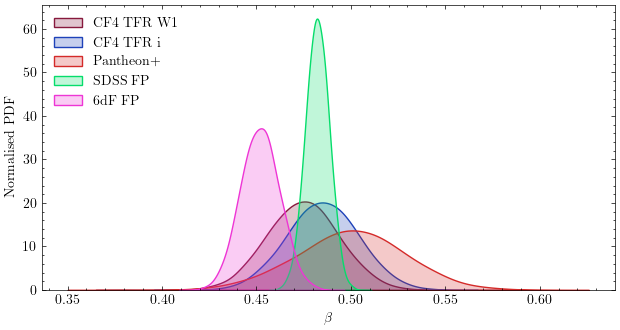

In [18]:
bw = 0.25


with plt.style.context("science"):
    plt.figure(figsize=(6.4, 3.5))

    i = 0
    for beta, label in zip(beta_list, labels):
        sns.kdeplot(beta, label=label, fill=True, color=COLS[i], bw_method=bw)
        i += 1

    plt.xlabel(r"$\beta$")
    plt.ylabel("Normalised PDF")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

### Stacked posteriors on $S_8$

Building SR interpolator: 100%|██████████| 100/100 [00:00<00:00, 134.27it/s]


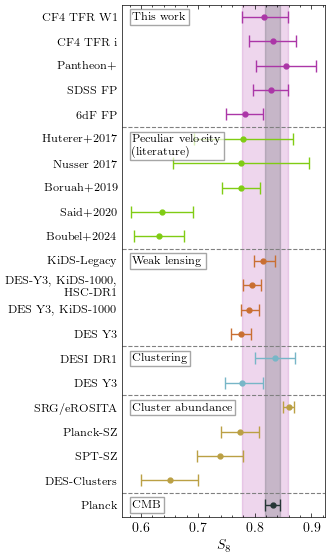

In [9]:

# --- This work ---
S8_list   = compute_S8_all(fnames, beta2cosmo)
this_names = labels
means_this = [np.mean(x) for x in S8_list]
errs_this  = [(np.percentile(x, 16), np.percentile(x, 84)) for x in S8_list]
lower_this = [a for a, _ in errs_this]
upper_this = [b for _, b in errs_this]

# --- Literature blocks ---
lit_blocks = {
    "pv": [
        ("Huterer+2017", 0.780, 0.087),
        ("Nusser 2017",  0.776, 0.120),
        ("Boruah+2019",  0.776, 0.033),
        ("Said+2020",    0.637, 0.054),
        ("Boubel+2024",  0.632, 0.044),
    ],
    "wl": [
        ("KiDS-Legacy",              0.814, (0.016, 0.021)),
        ("DES-Y3, KiDS-1000,\nHSC-DR1", 0.795, (0.015, 0.017)),
        ("DES Y3, KiDS-1000",        0.790, (0.014, 0.018)),
        ("DES Y3",                   0.776, 0.017),
    ],
    "clustering": [
        ("DESI DR1", 0.836, 0.035),
        ("DES Y3",   0.778, (0.031, 0.037)),
    ],
    "clusters": [
        ("SRG/eROSITA",  0.86,  0.01),
        ("Planck-SZ",    0.774, 0.034),
        ("SPT-SZ",       0.739, 0.041),
        ("DES-Clusters", 0.650, 0.050),
    ],
    "cmb": [
        ("Planck", 0.832, 0.013),
    ],
}

# Flatten
lit_names, lit_means, lit_errs = [], [], []
for group in ["pv", "wl", "clustering", "clusters", "cmb"]:
    for name, m, s in lit_blocks[group]:
        lit_names.append(name)
        lit_means.append(m)
        lit_errs.append(s)

# Convert symmetric/asymmetric errors to bounds
def _to_bounds(means, errs):
    lows, ups = [], []
    for m, e in zip(means, errs):
        if isinstance(e, tuple):
            lows.append(m - e[0]); ups.append(m + e[1])
        else:
            lows.append(m - e);    ups.append(m + e)
    return lows, ups

lower_lit, upper_lit = _to_bounds(lit_means, lit_errs)

# Combine
names = this_names + lit_names
means = means_this + lit_means
lower = lower_this + lower_lit
upper = upper_this + upper_lit
err_lo = np.array(means) - np.array(lower)
err_hi = np.array(upper) - np.array(means)

# --- Block sizes for dividers ---
n_this = len(this_names)
n_pv   = len(lit_blocks["pv"])
n_wl   = len(lit_blocks["wl"])
n_cl   = len(lit_blocks["clustering"])
n_cls  = len(lit_blocks["clusters"])
n_cmb  = len(lit_blocks["cmb"])
block_sizes  = [n_this, n_pv, n_wl, n_cl, n_cls, n_cmb]
block_labels = ["This work", "Peculiar velocity\n(literature)", "Weak lensing",
                "Clustering", "Cluster abundance", "CMB"]

# Colors per block
# tab = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"]
tab = ["#263636", "#BBA044", "#77B6C7", "#C96F32", "#80CC14", "#AB36A7"][::-1]
colors = (
    [tab[0]] * n_this +
    [tab[1]] * n_pv +
    [tab[2]] * n_wl +
    [tab[3]] * n_cl +
    [tab[4]] * n_cls +
    [tab[5]] * n_cmb
)

# --- Plot ---
with plt.style.context("science"):  # requires SciencePlots (or use 'default')
    fig, ax = plt.subplots(figsize=(3.5, 2.625 * 2.2))

    # Set y-limits early so the spans visually cover the full panel
    ax.set_ylim(0.5, len(names) + 0.5)

    # -------- Full-height shaded 1σ bands --------
    # (1) First "This work" entry (index 0)
    if len(means_this) > 0:
        this_mu0 = means_this[0]
        this_lo0 = lower_this[0]
        this_hi0 = upper_this[0]
        ax.axvspan(this_lo0, this_hi0, ymin=0, ymax=1, color=colors[0], alpha=0.2, zorder=0)

    # (2) Planck (CMB)
    # Get Planck mean and error from the lit_blocks["cmb"] entry
    planck_name, planck_m, planck_s = lit_blocks["cmb"][0]
    if isinstance(planck_s, tuple):
        planck_lo, planck_hi = planck_m - planck_s[0], planck_m + planck_s[1]
    else:
        planck_lo, planck_hi = planck_m - planck_s, planck_m + planck_s
    ax.axvspan(planck_lo, planck_hi, ymin=0, ymax=1, color=colors[-1], alpha=0.2, zorder=0)
    # ---------------------------------------------

    # Points with horizontal error bars
    for i, (name, mu, elo, ehi, color) in enumerate(zip(names, means, err_lo, err_hi, colors), start=1):
        ax.errorbar(mu, i, xerr=[[elo],[ehi]], fmt="o", color=color, capsize=4, ms=3.5)

    # Dividers
    cumulative = np.cumsum(block_sizes)
    for y in cumulative[:-1] + 0.5:
        ax.axhline(y, color="0.5", linestyle="--", lw=0.8)

    # Group labels
    starts = np.concatenate(([0], cumulative[:-1]))
    tform = ax.get_yaxis_transform()
    for start, size, label in zip(starts, block_sizes, block_labels):
        if size == 0:
            continue
        y = start + 0.8
        ax.text(0.05, y, label, transform=tform,
                ha="left", va="top", fontsize="small", weight="bold",
                bbox=dict(facecolor="white", edgecolor="0.5", alpha=0.7, pad=2.0))

    ax.set_yticks(range(1, len(names) + 1), names, fontsize="small")
    ax.tick_params(axis="y", which="both", length=0)
    ax.set_xlabel(r"$S_8$")
    ax.invert_yaxis()
    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/S8_comparison.pdf", dpi=450, bbox_inches="tight")
    plt.show()

### Figure: Posterior of $V_{\rm ext}$

precomputed_los_Carrick2015_CF4_W1_MNR_linear_eta_sampled.hdf5: R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, a_TFR, b1, b_TFR, beta, c_TFR, eta_latent, eta_prior_mean, eta_prior_std, n_dist_emp, p_dist_emp, sigma_int, sigma_v
precomputed_los_Carrick2015_CF4_i_MNR_linear_eta_sampled.hdf5: R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, a_TFR, b1, b_TFR, beta, c_TFR, eta_latent, eta_prior_mean, eta_prior_std, n_dist_emp, p_dist_emp, sigma_int, sigma_v
precomputed_los_Carrick2015_PantheonPlus_MNR_linear.hdf5: M, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, b1, beta, n_dist_emp, p_dist_emp, r_latent, sigma_int, sigma_v
precomputed_los_Carrick2015_SDSS_FP_noMNR_linear.hdf5: R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, a_FP, b1, b_FP, beta, c_FP, n_dist_emp, p_dist_emp, sigma_log_theta, sigma_v
precomputed_los_Carrick2015_6dF_FP_noMNR_linear.hdf5: R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, a_FP, b1, b_FP, beta, c_FP, n_dist_emp, p_dist_emp, sigma_log_theta, sigma_v
Removed no burn in
Rem

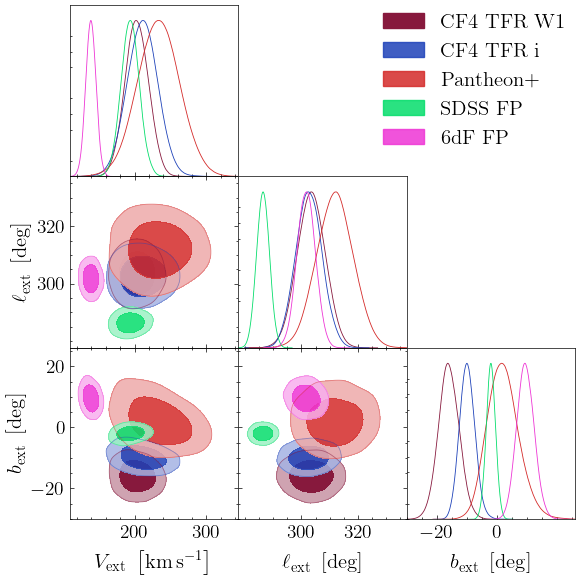

In [20]:
candel.plot_corner_from_hdf5(
    fnames,
    fontsize=18,
    filled=True,
    labels=labels,
    cols=COLS,
    keys=["Vext_mag", "Vext_ell", "Vext_b"],
    filename="/Users/rstiskalek/Downloads/Vext.pdf",
    )

### Angular separation between $V_{\rm ext}$

Angular separation between SDSS FP and Pantheon+: 26.45 ± 6.75 deg


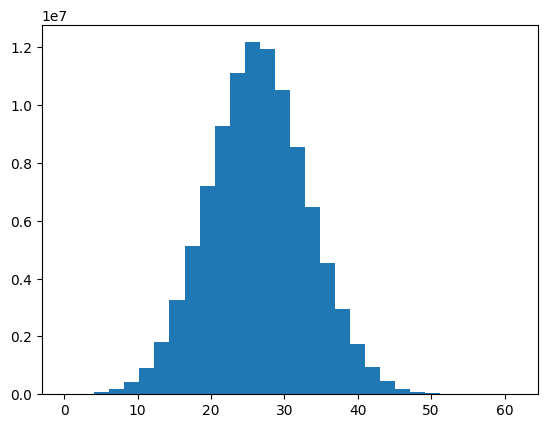

In [75]:
from scipy.spatial import distance

b_list = get_key_all(fnames, "Vext_b")
ell_list = get_key_all(fnames, "Vext_ell")


i = labels.index("SDSS FP")
j = labels.index("Pantheon+")

def angsep_scipy(l1, b1, l2, b2):
    # convert to unit vectors
    def sph2cart(l, b):
        l = np.deg2rad(l); b = np.deg2rad(b)
        return np.c_[np.cos(b)*np.cos(l), np.cos(b)*np.sin(l), np.sin(b)]
    v1, v2 = sph2cart(l1, b1), sph2cart(l2, b2)
    cosang = 1 - distance.cdist(v1, v2, "sqeuclidean")/2
    return np.rad2deg(np.arccos(np.clip(cosang, -1, 1)))

dx = angsep_scipy(ell_list[i], b_list[i], ell_list[j], b_list[j]).flatten()

print(f"Angular separation between SDSS FP and Pantheon+: {np.mean(dx):.2f} ± {np.std(dx):.2f} deg")

plt.figure()
plt.hist(dx, bins=30)
plt.show()

### Figure: $b_1$ vs $\beta$

In [4]:
from glob import glob



def read_b1_beta(glob_root, b1_min):
    b1 = []
    beta_mean = []
    beta_std = []

    files = glob(glob_root)
    for f in files:
        b1_val = float(f.split("b1_")[-1].split(".hdf5")[0])
        b1.append(b1_val)

        beta_samples = candel.read_samples("", f, "beta")
        beta_mean.append(np.mean(beta_samples))
        beta_std.append(np.std(beta_samples))
    
    b1, beta_mean, beta_std = np.array(b1), np.array(beta_mean), np.array(beta_std)
    ks = np.argsort(b1)


    b1, beta_mean, beta_std = b1[ks], beta_mean[ks], beta_std[ks]
    mask = b1 >= b1_min
    return b1[mask], beta_mean[mask], beta_std[mask]



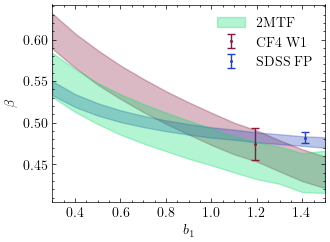

In [8]:
b1_min = 0.25

with plt.style.context("science"):
    plt.figure(figsize=(3.5, 0.75 * 3.5))

    # --- CF4 W1 ---
    b1, beta_mean, beta_std = read_b1_beta(
        join(root, "precomputed_los_Carrick2015_CF4_W1_noMNR_linear_b1_*.hdf5"),
        b1_min=b1_min
    )
    plt.fill_between(b1, beta_mean - beta_std, beta_mean + beta_std,
                     color=COLS[0], alpha=0.3)

    d = candel.read_samples(
        root, "precomputed_los_Carrick2015_CF4_W1_MNR_linear_eta_sampled.hdf5",
        ["b1", "beta"]
    )
    plt.errorbar(np.mean(d["b1"]), np.mean(d["beta"]),
                 xerr=None, yerr=np.std(d["beta"]),
                 fmt="s", ms=1, capsize=3, 
                 label="CF4 W1", color=COLS[0], zorder=100)

    # --- SDSS FP ---
    b1, beta_mean, beta_std = read_b1_beta(
        join(root, "precomputed_los_Carrick2015_SDSS_FP_noMNR_linear_b1_*.hdf5"),
        b1_min=b1_min,
    )
    plt.fill_between(b1, beta_mean - beta_std, beta_mean + beta_std,
                     color=COLS[1], alpha=0.3)

    d = candel.read_samples(
        root, "precomputed_los_Carrick2015_SDSS_FP_noMNR_linear.hdf5",
        ["b1", "beta"]
    )
    plt.errorbar(np.mean(d["b1"]), np.mean(d["beta"]),
                 xerr=None, yerr=np.std(d["beta"]),
                 fmt="D", ms=1, capsize=3, lw=1,
                 label="SDSS FP", color=COLS[1], zorder=100)

    # --- 2MTF ---
    b1, beta_mean, beta_std = read_b1_beta(
        join(root, "precomputed_los_Carrick2015_2MTF_noMNR_linear_b1_*.hdf5"),
        b1_min=b1_min
    )
    plt.fill_between(b1, beta_mean - beta_std, beta_mean + beta_std,
                     color=COLS[3], alpha=0.3, label="2MTF")

    # d = candel.read_samples(
    #     root, "precomputed_los_Carrick2015_2MTF_MNR_linear_eta_sampled.hdf5",
    #     ["b1", "beta"]
    # )
    # plt.errorbar(np.mean(d["b1"]), np.mean(d["beta"]),
    #              xerr=None, yerr=np.std(d["beta"]),
    #              fmt="s", ms=1, capsize=3, 
    #              label="2MTF", color=COLS[2], zorder=100)

    plt.xlim(0.3, 1.5)
    # plt.ylim(None, 0.6)
    
    plt.xlabel(r"$b_1$")
    plt.ylabel(r"$\beta$")
    plt.legend()

    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/b1_beta.pdf", bbox_inches="tight", dpi=450)

    plt.show()

In [18]:
for i in range(len(b1)):
    print(f"{b1[i]:.2f} | {beta_mean[i]:.3f} ± {beta_std[i]:.3f}")

0.30 | 0.558 ± 0.027
0.40 | 0.539 ± 0.026
0.50 | 0.523 ± 0.025
0.60 | 0.510 ± 0.024
0.70 | 0.499 ± 0.024
0.80 | 0.489 ± 0.023
0.90 | 0.480 ± 0.023
1.00 | 0.471 ± 0.022
1.10 | 0.462 ± 0.022
1.20 | 0.455 ± 0.022
1.30 | 0.449 ± 0.022
1.40 | 0.440 ± 0.023
1.50 | 0.441 ± 0.025


### Figure: 2PCF comparison

In [3]:
from halotools.mock_observables import tpcf


from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
cosmo = FlatLambdaCDM(H0=100, Om0=0.3)

def positions_from_dict(d, zmax=None, nrand=0, rng=None):
    ra = np.deg2rad(d["RA"])
    dec = np.deg2rad(d["dec"])
    z = d["zcmb"]

    if zmax is not None:
        m = z < zmax
        ra, dec, z = ra[m], dec[m], z[m]

    r = cosmo.comoving_distance(z).to(u.Mpc).value
    x = r * np.cos(dec) * np.cos(ra)
    y = r * np.cos(dec) * np.sin(ra)
    zc = r * np.sin(dec)
    data_pos = np.vstack((x, y, zc)).T

    rand_pos = None
    if nrand and nrand > 0:
        if rng is None:
            rng = np.random.default_rng()
        n = ra.size
        n_out = n * nrand

        # sample directions (as pairs) from data
        idx_dir = rng.integers(0, n, size=n_out)
        ra_rand = ra[idx_dir]
        dec_rand = dec[idx_dir]

        # sample distances independently from data
        idx_r = rng.integers(0, n, size=n_out)
        r_rand = r[idx_r]

        x = r_rand * np.cos(dec_rand) * np.cos(ra_rand)
        y = r_rand * np.cos(dec_rand) * np.sin(ra_rand)
        zc = r_rand * np.sin(dec_rand)
        rand_pos = np.vstack((x, y, zc)).T

    return data_pos, rand_pos

In [4]:
import os
import joblib

# --- cache file (edit path/name if you like) ---
cache_path = "/Users/rstiskalek/Projects/CANDEL/notebooks/paper_S8/xi_cache.joblib"

if os.path.exists(cache_path):
    data, labels_xi, xi_list, x_rbin = joblib.load(cache_path)
    print(f"Loaded cached results from: {cache_path}")
else:
    # --- bins ---
    r_bins = np.logspace(np.log10(0.5), np.log10(25), 15)
    x_rbin = 0.5 * (r_bins[1:] + r_bins[:-1])

    # --- load datasets ---
    CF4_i = candel.pvdata.load_CF4_data("/Users/rstiskalek/Projects/CANDEL/data/CF4", "i", zcmb_max=0.05)
    CF4_W1 = candel.pvdata.load_CF4_data("/Users/rstiskalek/Projects/CANDEL/data/CF4", "w1", zcmb_max=0.05)
    SDSS_FP = candel.pvdata.load_SDSS_FP("/Users/rstiskalek/Projects/CANDEL/data/SDSS", zcmb_max=0.05)
    FP_6dF = candel.pvdata.load_6dF_FP("/Users/rstiskalek/Projects/CANDEL/data/6dF_FP", which_band="J", zcmb_max=0.05)
    PP = candel.pvdata.load_PantheonPlus("/Users/rstiskalek/Projects/CANDEL/data/Pantheon+", zcmb_max=0.05)

    data_2mpp = np.genfromtxt("/Users/rstiskalek/Projects/CANDEL/data/2M++/2M++_galaxy_catalog.dat", delimiter="|")
    data_2mpp = dict(RA=data_2mpp[:, 1], dec=data_2mpp[:, 2], zcmb=data_2mpp[:, 7] / candel.SPEED_OF_LIGHT)
    mask_2mpp = data_2mpp["zcmb"] < 0.05
    data_2mpp = {k: v[mask_2mpp] for k, v in data_2mpp.items()}

    data = [CF4_i, CF4_W1, SDSS_FP, FP_6dF, PP, data_2mpp]
    labels_xi = ["CF4 TFR i", "CF4 TFR W1", "SDSS FP", "6dF FP", "Pantheon+", "2M++"]

    # --- compute xi for each dataset ---
    xi_list = []
    for d, label in zip(data, labels_xi):
        nrand = 50 if label != "2M++" else 10
        pos, rand = positions_from_dict(d, nrand=nrand)
        xi = tpcf(
            pos,
            r_bins,
            randoms=rand,
            estimator="Landy-Szalay",
            num_threads=8,
        )
        xi_list.append(xi)
        print(f"{label}: computed xi with {len(pos)} galaxies")

    # --- save cache ---
    joblib.dump((data, labels_xi, xi_list, x_rbin), cache_path)
    print(f"Saved results to: {cache_path}")

2025-09-05 18:47:50 initially loaded 9788 galaxies from CF4 TFR data.
2025-09-05 18:47:50 removed 4815 galaxies, thus 4973 remain.
2025-09-05 18:47:50 initially loaded 9788 galaxies from CF4 TFR data.
2025-09-05 18:47:50 removed 6542 galaxies, thus 3246 remain.
2025-09-05 18:47:50 initially loaded 34059 galaxies from SDSS FP data.
2025-09-05 18:47:50 removed 26612 galaxies, thus 7447 remain.
2025-09-05 18:47:50 initially loaded 11102 galaxies from 6dF FP data.
2025-09-05 18:47:50 removed 2380 galaxies, thus 8722 remain.
2025-09-05 18:47:50 initially loaded 618 galaxies from Pantheon+ data.
2025-09-05 18:47:50 removed 93 galaxies, thus 525 remain.
CF4 TFR i: computed xi with 4973 galaxies
CF4 TFR W1: computed xi with 3246 galaxies
SDSS FP: computed xi with 7447 galaxies
6dF FP: computed xi with 8722 galaxies
Pantheon+: computed xi with 525 galaxies
2M++: computed xi with 55844 galaxies
Saved results to: /Users/rstiskalek/Projects/CANDEL/notebooks/paper_S8/xi_cache.joblib


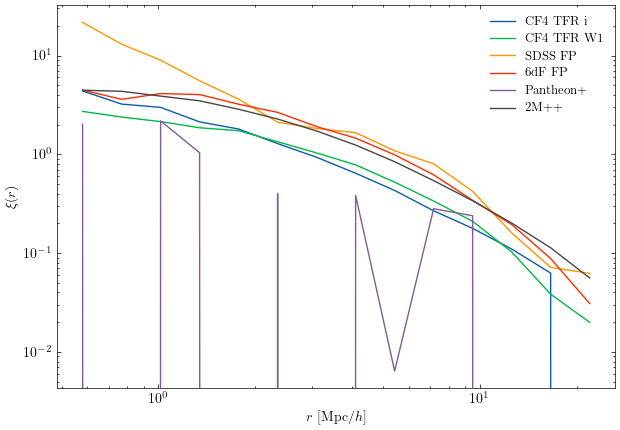

In [7]:
with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(6.4, 4.5))

    for xi, label in zip(xi_list, labels_xi):
        ax.plot(x_rbin, xi,  label=label)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel(r"$r~[{\rm Mpc}/h]$")
    ax.set_ylabel(r"$\xi(r)$")

    ax.legend(frameon=False, fontsize=9)

    fig.tight_layout()
    # fig.savefig("/Users/rstiskalek/Downloads/cf4_xi.pdf", dpi=300)
    plt.show()